In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Installation


In [ ]:
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-3iu9z1dn
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-3iu9z1dn
  Resolved https://github.com/AI4Finance-LLC/FinRL-Library.git to commit d25d902a6de54931a329adc38a2663e8f576adc4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-4cwaw3c8/elegantrl_b98a6596f0ae49c5ba01364c3b29667b
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-4cwaw3c8/elegantrl_b98a6596f0ae49c5ba01364c3b29667b
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 5e828af1503098f4da046c0f12432dbd4ef8bd97
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.

In [ ]:
!pip install selenium webdriver-manager alpaca-py datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.


In [ ]:
!git clone https://github.com/benstaf/FinRL_DeepSeek.git
%cd FinRL_DeepSeek

Cloning into 'FinRL_DeepSeek'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 145 (delta 94), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (145/145), 1.21 MiB | 6.50 MiB/s, done.
Resolving deltas: 100% (94/94), done.
/content/FinRL_DeepSeek


In [ ]:
import sys
sys.path.append("/content/FinRL_DeepSeek/")

In [ ]:
!git clone https://huggingface.co/benstaf/Trading_agents

Cloning into 'Trading_agents'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 20 (delta 0), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (20/20), 4.12 KiB | 383.00 KiB/s, done.
Filtering content: 100% (15/15), 87.22 MiB | 38.83 MiB/s, done.


In [ ]:
!pip install pandas_market_calendars
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.0/123.0 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.4/198.4 kB 17.1 MB/s eta 0:00:00


# Import libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

#from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR
from env_stocktrading import StockTradingEnv


# Import PPO-DeepSeek environments
from env_stocktrading_llm import StockTradingEnv as StockTradingEnv_llm
from env_stocktrading_llm_1 import StockTradingEnv as StockTradingEnv_llm_1
from env_stocktrading_llm_01 import StockTradingEnv as StockTradingEnv_llm_01

# Import CPPO-DeepSeek risk environments
from env_stocktrading_llm_risk import StockTradingEnv as StockTradingEnv_llm_risk
from env_stocktrading_llm_risk_1 import StockTradingEnv as StockTradingEnv_llm_risk_1
from env_stocktrading_llm_risk_01 import StockTradingEnv as StockTradingEnv_llm_risk_01

#from env_stocktrading_llm import StockTradingEnv as StockTradingEnv_llm

#from env_stocktrading_llm_risk import StockTradingEnv as StockTradingEnv_llm_risk


#from finrl.meta.env_stock_trading.env_stocktrading_llm import StockTradingEnv
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader


from datasets import load_dataset

%matplotlib inline

# Part2.Backtesting

In [ ]:
# from Huggging Face :
dataset = load_dataset("benstaf/nasdaq_2013_2023", data_files='trade_data_deepseek_sentiment_2019_2023.csv')

# Convert to pandas DataFrame
trade = pd.DataFrame(dataset['train'])

#trade= pd.read_csv('/content/machine_learning/trade_data_qwen_sentiment.csv')

trade = trade.drop('Unnamed: 0',axis=1)

# Create a new index based on unique dates
unique_dates = trade['date'].unique()
date_to_idx = {date: idx for idx, date in enumerate(unique_dates)}

# Create new index based on the date mapping
trade['new_idx'] = trade['date'].map(date_to_idx)

# Set this as the index
trade = trade.set_index('new_idx')


#missing values with 0
trade['llm_sentiment'].fillna(0, inplace=True)
trade_llm=trade.copy()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


(…)de_data_deepseek_sentiment_2019_2023.csv:   0%|          | 0.00/31.0M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

<ipython-input-9-96cd1ee5a3d7>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  trade['llm_sentiment'].fillna(0, inplace=True)


###  Reducing size from 84 to 8 companies

In [ ]:
tickers = ['AMD', 'ADBE', 'PYPL', 'CSCO', 'NFLX', 'NVDA', 'EBAY', 'MNST', 'GOOGL']
trade = trade[
    (trade['tic'].isin(tickers))
].sort_values(by='date')

# Step 3: Create a mapping from unique dates to a new index
date_to_idx = {date: idx for idx, date in enumerate(sorted(trade['date'].unique()))}

# Step 4: Map that to a new column
trade['new_idx'] = trade['date'].map(date_to_idx)

# Step 5: Set new_idx as the actual DataFrame index
trade.set_index('new_idx', inplace=True)

In [ ]:
if 'new_idx' in trade.columns:
    trade.drop(columns='new_idx', inplace=True)

In [ ]:
trade.head()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,llm_sentiment
new_idx,,,,,,,,,,,,,,,,,,,
0,2019-01-02,ADBE,224.570007,226.169998,219.000000,219.910004,2784100.0,2.0,-5.282335,259.815658,203.146343,45.781002,-54.094692,18.279805,232.429000,239.189334,23.219999,91.011025,5.0
0,2019-01-02,AMD,18.830000,19.000000,17.980000,18.010000,87148700.0,2.0,-0.800179,22.588778,15.842221,46.067794,-52.118450,6.093693,19.553333,21.073667,23.219999,91.011025,1.0
0,2019-01-02,CSCO,35.501106,43.200001,42.209999,42.279999,23833500.0,2.0,-0.844018,41.168029,32.894947,44.872578,-87.839582,29.529377,37.367488,37.612567,23.219999,91.011025,3.0
0,2019-01-02,EBAY,26.067905,28.959999,27.559999,27.650000,11190300.0,2.0,-0.277861,27.439666,24.065448,47.306261,-16.417715,2.502926,25.833276,26.370597,23.219999,91.011025,3.0
0,2019-01-02,GOOGL,52.543530,53.039501,51.264000,51.360001,31868000.0,2.0,-0.419759,55.115100,49.348164,47.694966,-19.718509,9.639811,52.430436,53.424698,23.219999,91.011025,3.0


In [ ]:
trade.shape

(10056, 19)

In [ ]:
trade_llm=trade.copy()

In [ ]:
trade_llm.head()

,date,tic,close,high,low,open,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,llm_sentiment
new_idx,,,,,,,,,,,,,,,,,,,
0,2019-01-02,ADBE,224.570007,226.169998,219.000000,219.910004,2784100.0,2.0,-5.282335,259.815658,203.146343,45.781002,-54.094692,18.279805,232.429000,239.189334,23.219999,91.011025,5.0
0,2019-01-02,AMD,18.830000,19.000000,17.980000,18.010000,87148700.0,2.0,-0.800179,22.588778,15.842221,46.067794,-52.118450,6.093693,19.553333,21.073667,23.219999,91.011025,1.0
0,2019-01-02,CSCO,35.501106,43.200001,42.209999,42.279999,23833500.0,2.0,-0.844018,41.168029,32.894947,44.872578,-87.839582,29.529377,37.367488,37.612567,23.219999,91.011025,3.0
0,2019-01-02,EBAY,26.067905,28.959999,27.559999,27.650000,11190300.0,2.0,-0.277861,27.439666,24.065448,47.306261,-16.417715,2.502926,25.833276,26.370597,23.219999,91.011025,3.0
0,2019-01-02,GOOGL,52.543530,53.039501,51.264000,51.360001,31868000.0,2.0,-0.419759,55.115100,49.348164,47.694966,-19.718509,9.639811,52.430436,53.424698,23.219999,91.011025,3.0


In [ ]:
len(trade_llm['date'].unique())

1257

### Continue with base code

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [ ]:
stock_dimension_llm = len(trade_llm.tic.unique())
state_space_llm = 1 + 2 * stock_dimension_llm + (1+len(INDICATORS)) * stock_dimension_llm #+ stock_dimension # +LLM sentiment
print(f"Stock Dimension: {stock_dimension_llm}, State Space: {state_space_llm}")


Stock Dimension: 8, State Space: 89


In [ ]:
buy_cost_list_llm = sell_cost_list_llm = [0.001] * stock_dimension_llm
num_stock_shares_llm = [0] * stock_dimension_llm
#Environment indicators + sentiments
env_kwargs_llm = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares_llm,
    "buy_cost_pct": buy_cost_list_llm,
    "sell_cost_pct": sell_cost_list_llm,
    "state_space": state_space_llm,
    "stock_dim": stock_dimension_llm,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension_llm,
    "reward_scaling": 1e-4
}

In [ ]:
e_trade_llm_gym = StockTradingEnv_llm(df = trade_llm, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs_llm)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [ ]:
observation_space_llm=e_trade_llm_gym.observation_space
action_space_llm=e_trade_llm_gym.action_space

In [ ]:
print("observation shape:", observation_space_llm.shape)

observation shape: (89,)


In [ ]:
print("action shape:", action_space_llm.shape)

action shape: (8,)


In [ ]:

import numpy as np
import scipy.signal
from gymnasium.spaces import Box, Discrete

import torch
import torch.nn as nn
from torch.distributions.normal import Normal
from torch.distributions.categorical import Categorical


def combined_shape(length, shape=None):
    if shape is None:
        return (length,)
    return (length, shape) if np.isscalar(shape) else (length, *shape)


def mlp(sizes, activation, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)


def count_vars(module):
    return sum([np.prod(p.shape) for p in module.parameters()])


def discount_cumsum(x, discount):
    """
    magic from rllab for computing discounted cumulative sums of vectors.

    input:
        vector x,
        [x0,
         x1,
         x2]

    output:
        [x0 + discount * x1 + discount^2 * x2,
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-discount)], x[::-1], axis=0)[::-1]


class Actor(nn.Module):

    def _distribution(self, obs):
        raise NotImplementedError

    def _log_prob_from_distribution(self, pi, act):
        raise NotImplementedError

    def forward(self, obs, act=None):
        # Produce action distributions for given observations, and
        # optionally compute the log likelihood of given actions under
        # those distributions.
        pi = self._distribution(obs)
        logp_a = None
        if act is not None:
            logp_a = self._log_prob_from_distribution(pi, act)
        return pi, logp_a


class MLPCategoricalActor(Actor):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        self.logits_net = mlp([obs_dim] + list(hidden_sizes) + [act_dim], activation)

    def _distribution(self, obs):
        logits = self.logits_net(obs)
        return Categorical(logits=logits)

    def _log_prob_from_distribution(self, pi, act):
        return pi.log_prob(act)


class MLPGaussianActor(Actor):

    def __init__(self, obs_dim, act_dim, hidden_sizes, activation):
        super().__init__()
        log_std = -0.5 * np.ones(act_dim, dtype=np.float32)
        self.log_std = torch.nn.Parameter(torch.as_tensor(log_std))
        self.mu_net = mlp([obs_dim] + list(hidden_sizes) + [act_dim], activation)

    def _distribution(self, obs):
        mu = self.mu_net(obs)
        std = torch.exp(self.log_std)
        return Normal(mu, std)

    def _log_prob_from_distribution(self, pi, act):
        return pi.log_prob(act).sum(axis=-1)    # Last axis sum needed for Torch Normal distribution


class MLPCritic(nn.Module):

    def __init__(self, obs_dim, hidden_sizes, activation):
        super().__init__()
        self.v_net = mlp([obs_dim] + list(hidden_sizes) + [1], activation)

    def forward(self, obs):
        return torch.squeeze(self.v_net(obs), -1) # Critical to ensure v has right shape.



class MLPActorCritic(nn.Module):
    def __init__(self, observation_space, action_space,
                 hidden_sizes=(64, 64), activation=nn.Tanh):
        super().__init__()

        obs_dim = observation_space.shape[0]

        # policy builder depends on action space
        if isinstance(action_space, Box):
            self.pi = MLPGaussianActor(obs_dim, action_space.shape[0], hidden_sizes, activation)
        elif isinstance(action_space, Discrete):
            self.pi = MLPCategoricalActor(obs_dim, action_space.n, hidden_sizes, activation)

        # build value function
        self.v = MLPCritic(obs_dim, hidden_sizes, activation)

    def step(self, obs):
        with torch.no_grad():
            pi = self.pi._distribution(obs)
            a = pi.sample()
            logp_a = self.pi._log_prob_from_distribution(pi, a)
            v = self.v(obs)
        return a.numpy(), v.numpy(), logp_a.numpy()

    def act(self, obs):
        return self.step(obs)[0]

In [ ]:
!dir

env_stocktrading_llama.py
env_stocktrading_llama_risk.py
env_stocktrading_llm_01.py
env_stocktrading_llm_1.py
env_stocktrading_llm.py
env_stocktrading_llm_risk_01.py
env_stocktrading_llm_risk_1.py
env_stocktrading_llm_risk.py
env_stocktrading.py
FinRL_DeepSeek_backtesting.ipynb
hugging_face_upload.py
IMG_20250207_175434_001.jpg
installation_script.sh
LICENSE
output_cppo_deepseek_risk_100_epochs_01.log
output_cppo_deepseek_risk_100_epochs_99_101.log
output_cppo_deepseek_risk_100_epochs.log
output_cppo_llama_risk_100_epochs_98_95.log
output_cppo_llama_risk.log
output_cppo.log
output_cppo_risk_deepseek.log
output_ppo_deepseek_100_epochs_01.log
output_ppo_deepseek_100_epochs_96_104_bumps.log
output_ppo_deepseek_100_epochs_99_101_bumps.log
output_ppo_deepseek.log
output_ppo_llama_100_epochs_98_95_sentiment.log
output_ppo_llama.log
output_ppo_llm_deepseek.log
output_ppo.log
__pycache__
README.md
risk_deepseek_deepinfra.py
sentiment_deepseek_deepinfra.py
Trading_agents
train_cppo_llama_risk.p

finRL_working_subset_train_ppo_llm_50_epochs_8k_steps_

In [ ]:
# Load the model
loaded_ppo_llm = MLPActorCritic(observation_space_llm,action_space_llm, hidden_sizes=(512, 512))

loaded_ppo_llm.load_state_dict(torch.load('/content/drive/MyDrive/FinRL/finrl_ppo_models/MIST_1_ppo_deepseek_50_epochs_8k_steps_01_cpu.pth'))

loaded_ppo_llm.eval()  # Set the model to evaluation mode

MLPActorCritic(
  (pi): MLPGaussianActor(
    (mu_net): Sequential(
      (0): Linear(in_features=89, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Tanh()
      (4): Linear(in_features=512, out_features=8, bias=True)
      (5): Identity()
    )
  )
  (v): MLPCritic(
    (v_net): Sequential(
      (0): Linear(in_features=89, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Tanh()
      (4): Linear(in_features=512, out_features=1, bias=True)
      (5): Identity()
    )
  )
)

MIST_1_ppo_deepseek_50_epochs_8k_steps_01

In [ ]:
# Load the model
loaded_ppo_llm_mist = MLPActorCritic(observation_space_llm,action_space_llm, hidden_sizes=(512, 512))

loaded_ppo_llm_mist.load_state_dict(torch.load('/content/drive/MyDrive/FinRL/finrl_ppo_models/MIST_1_ppo_deepseek_50_epochs_8k_steps_01_cpu.pth'))


loaded_ppo_llm_mist.eval()  # Set the model to evaluation mode

MLPActorCritic(
  (pi): MLPGaussianActor(
    (mu_net): Sequential(
      (0): Linear(in_features=89, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Tanh()
      (4): Linear(in_features=512, out_features=8, bias=True)
      (5): Identity()
    )
  )
  (v): MLPCritic(
    (v_net): Sequential(
      (0): Linear(in_features=89, out_features=512, bias=True)
      (1): Tanh()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): Tanh()
      (4): Linear(in_features=512, out_features=1, bias=True)
      (5): Identity()
    )
  )
)

In [ ]:

def DRL_prediction(act, environment):
    import torch
    _torch = torch

    state, _ = environment.reset()
    account_memory = []  # To store portfolio values
    actions_memory = []  # To store actions taken
    portfolio_distribution = []  # To store portfolio distribution
    episode_total_assets = [environment.initial_amount]

    with _torch.no_grad():
        for i in range(len(environment.df.index.unique())):
            s_tensor = _torch.as_tensor((state,), dtype=torch.float32, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
            a_tensor, _, _ = act.step(s_tensor)  # Compute action
            action = a_tensor[0]  # Extract action

            # Step through the environment
            state, reward, done, _, _ = environment.step(action)

            # Get stock prices for the current day
            price_array = environment.df.loc[environment.day, "close"].values

            # Stock holdings and cash balance
            stock_holdings = environment.num_stock_shares
            cash_balance = environment.asset_memory[-1]

            # Calculate total portfolio value
            total_asset = cash_balance + (price_array * stock_holdings).sum()

            # Calculate portfolio distribution
            stock_values = price_array * stock_holdings
            total_invested = stock_values.sum()
            distribution = stock_values / total_asset  # Fraction of each stock in the total portfolio
            cash_fraction = cash_balance / total_asset

            # Store results
            episode_total_assets.append(total_asset)
            account_memory.append(total_asset)
            actions_memory.append(action)
            portfolio_distribution.append({"cash": cash_fraction, "stocks": distribution.tolist()})

       #     print("Total Asset Value:", total_asset)
        #    print("Portfolio Distribution:", {"cash": cash_fraction, "stocks": distribution.tolist()})

            if done:
                break

    print("Test Finished!")
    return episode_total_assets, account_memory, actions_memory, portfolio_distribution

In [ ]:
df_assets_ppo_llm, df_account_value_ppo_llm, df_actions_ppo_llm, df_portfolio_distribution_ppo_llm = DRL_prediction(act=loaded_ppo_llm, environment=e_trade_llm_gym)

Test Finished!


# Part 4: NASDAQ 100 index

In [ ]:
TRAIN_START_DATE = '2013-01-01'
TRAIN_END_DATE = '2018-12-31'
TRADE_START_DATE = '2019-01-01'
TRADE_END_DATE = '2023-12-31'

In [ ]:
df_dji = YahooDownloader(
    start_date=TRADE_START_DATE, end_date=TRADE_END_DATE, ticker_list=["ndx"]
).fetch_data()

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (937, 8)


In [ ]:
len(df_dji)

937

In [ ]:
df_dji[:50]

Price,date,close,high,low,open,volume,tic,day
0,2020-02-11,9517.860352,9517.860352,9517.860352,9517.860352,0,ndx,1
1,2020-02-12,9613.200195,9613.200195,9613.200195,9613.200195,0,ndx,2
2,2020-02-13,9595.700195,9595.700195,9595.700195,9595.700195,0,ndx,3
3,2020-02-14,9623.580078,9623.580078,9623.580078,9623.580078,0,ndx,4
4,2020-02-18,9629.799805,9629.799805,9629.799805,9629.799805,0,ndx,1
5,2020-02-19,9718.730469,9718.730469,9718.730469,9718.730469,0,ndx,2
6,2020-02-20,9627.830078,9627.830078,9627.830078,9627.830078,0,ndx,3
7,2020-02-21,9446.690430,9446.690430,9446.690430,9446.690430,0,ndx,4
8,2020-02-24,9079.629883,9079.629883,9079.629883,9079.629883,0,ndx,0
9,2020-02-25,8834.870117,8834.870117,8834.870117,8834.870117,0,ndx,1


In [ ]:
df_dji = df_dji[["date", "close"]]
fst_day = df_dji["close"][0]
dji = pd.merge(
    df_dji["date"],
    df_dji["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
).set_index("date")

In [ ]:
dji.head(5)

,close
date,
2020-02-11,1.000000e+06
2020-02-12,1.010017e+06
2020-02-13,1.008178e+06
2020-02-14,1.011108e+06
2020-02-18,1.011761e+06


In [ ]:
fst_day = df_dji["close"].iloc[0]  # Safely get the first value
df_dji_normalized_close = list(df_dji["close"].div(fst_day).mul(1000000))

In [ ]:
#df_dji_normalized_close[0]
len(df_dji_normalized_close),

(937,)

<a id='4'></a>
# Part 5: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [ ]:
fst_day_ppo_llm = df_assets_ppo_llm[1]  # Safely get the first value
df_assets_ppo_llm_series = pd.Series(df_assets_ppo_llm[1:])
df_ppo_llm_normalized_close = list(df_assets_ppo_llm_series.div(fst_day_ppo_llm).mul(1000000))

In [ ]:
len(trade['date'].drop_duplicates().values)

1257

In [ ]:
def filter_to_common_dates(trade, df_dji, df_assets_ppo, df_dji_normalized_close):
    """
    Filters df_assets_ppo and df_dji_normalized_close based on the common dates from trade and df_dji.

    Parameters:
        trade (pd.DataFrame): DataFrame containing a 'date' column for the trade data.
        df_dji (pd.DataFrame): DataFrame containing a 'date' column for DJI data.
        df_assets_ppo (list or array-like): Values corresponding to trade['date'].
        df_dji_normalized_close (list or array-like): Values corresponding to df_dji['date'].

    Returns:
        pd.Series, pd.Series: Filtered series for df_assets_ppo and df_dji_normalized_close.
    """
    # Extract unique trading dates from trade and DJI dates
    trade_dates = pd.to_datetime(trade['date'].unique())
    dji_dates = pd.to_datetime(df_dji['date'].unique())


  #  first_date = trade_dates[0]
   # date_before_first = first_date - pd.DateOffset(days=1)

# Prepend the date before the first date to trade_dates
    #trade_dates = pd.DatetimeIndex([date_before_first] + trade_dates.tolist())

    # Convert inputs to pandas Series with their respective dates as indices
    df_assets_ppo_series = pd.Series(df_assets_ppo, index=trade_dates)
    df_dji_normalized_close_series = pd.Series(df_dji_normalized_close, index=dji_dates)

    # Find the common dates
    common_dates = trade_dates.intersection(dji_dates)

    # Filter both series to the common dates
    df_assets_ppo_filtered = df_assets_ppo_series.reindex(common_dates)
    df_dji_normalized_close_filtered = df_dji_normalized_close_series.reindex(common_dates)

    # Return the filtered series
    return df_assets_ppo_filtered, df_dji_normalized_close_filtered, common_dates

In [ ]:
df_assets_ppo_llm_filtered, df_dji_normalized_close_filtered, common_dates = filter_to_common_dates(trade, df_dji, df_ppo_llm_normalized_close, df_dji_normalized_close)

In [ ]:
df_dji_normalized_close_filtered[1]

<ipython-input-41-2c0c7ae63c3f>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_dji_normalized_close_filtered[1]


np.float64(1010016.9408069062)

In [ ]:
result = pd.DataFrame(
    {
        "PPO-DeepSeek 50 epochs": df_assets_ppo_llm_filtered,
      #  "PPO-DeepSeek_MIST-1 epochs": df_assets_ppo_llama_filtered,
        "Nasdaq-100 index": df_dji_normalized_close_filtered,
    }
)

# Display the result
print(result)

            PPO-DeepSeek 50 epochs  Nasdaq-100 index
2020-02-11            4.195833e+06      1.000000e+06
2020-02-12            4.518113e+06      1.010017e+06
2020-02-13            4.517224e+06      1.008178e+06
2020-02-14            4.242010e+06      1.011108e+06
2020-02-18            4.452997e+06      1.011761e+06
...                            ...               ...
2023-12-21            1.322643e+07      1.760628e+06
2023-12-22            5.036906e+06      1.762728e+06
2023-12-26            8.465201e+06      1.773346e+06
2023-12-27            1.681420e+07      1.776324e+06
2023-12-28            1.681420e+07      1.775448e+06

[936 rows x 2 columns]


In [ ]:
result

,PPO-DeepSeek 50 epochs,Nasdaq-100 index
2020-02-11,4.195833e+06,1.000000e+06
2020-02-12,4.518113e+06,1.010017e+06
2020-02-13,4.517224e+06,1.008178e+06
2020-02-14,4.242010e+06,1.011108e+06
2020-02-18,4.452997e+06,1.011761e+06
...,...,...
2023-12-21,1.322643e+07,1.760628e+06
2023-12-22,5.036906e+06,1.762728e+06
2023-12-26,8.465201e+06,1.773346e+06
2023-12-27,1.681420e+07,1.776324e+06


In [ ]:
result.to_csv('/content/ppo_deepseek_output_vs_nasdaq_100_index.csv')

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Utility Functions
def calculate_metric(returns_strategy, returns_benchmark, confidence_level=0.05, upside_confidence=0.95):
    """Calculate performance metrics: IR, CVaR, and Rachev Ratio."""
    excess_return = returns_strategy - returns_benchmark
    ir = excess_return.mean() / excess_return.std()
    var = np.percentile(returns_strategy, confidence_level * 100)
    cvar = returns_strategy[returns_strategy <= var].mean()
    upside_var = np.percentile(returns_strategy, upside_confidence * 100)
    downside_var = var
    rachev_ratio = returns_strategy[returns_strategy >= upside_var].mean() / abs(returns_strategy[returns_strategy <= downside_var].mean())
    return {"Information Ratio": ir, "CVaR": cvar, "Rachev Ratio": rachev_ratio}

def align_returns(result, col_strategy, col_benchmark):
    """Align returns for strategy and benchmark."""
    returns_strategy = result[col_strategy].pct_change().dropna()
    returns_benchmark = result[col_benchmark].pct_change().dropna()
    return returns_strategy.align(returns_benchmark, join="inner")

# Metrics Calculation
def compute_metrics(result, strategies, benchmark, confidence_level=0.05, upside_confidence=0.95):
    """
    Compute metrics for multiple strategies compared to a benchmark.

    Parameters:
        result (pd.DataFrame): DataFrame with strategies and benchmark columns.
        strategies (list): List of strategy column names.
        benchmark (str): Benchmark column name.
        confidence_level (float): Confidence level for CVaR calculation.
        upside_confidence (float): Confidence level for upside in Rachev Ratio.

    Returns:
        dict: Performance metrics for each strategy.
    """
    metrics = {}
    for strategy in strategies:
        aligned_strategy, aligned_benchmark = align_returns(result, strategy, benchmark)
        metrics[strategy] = calculate_metric(
            aligned_strategy, aligned_benchmark, confidence_level, upside_confidence
        )
    return metrics

# Plotting
def plot_cumulative_returns(result, metrics, strategies, benchmark):
    """
    Plot cumulative returns for strategies and benchmark with annotated metrics.

    Parameters:
        result (pd.DataFrame): DataFrame with strategies and benchmark.
        metrics (dict): Performance metrics.
        strategies (list): List of strategy column names.
        benchmark (str): Benchmark column name.
    """
    plt.figure(figsize=(12, 6))
    for strategy in strategies:
        cumulative_returns = (1 + result[strategy].pct_change().dropna()).cumprod()
        plt.plot(cumulative_returns, label=f"{strategy}")
    cumulative_benchmark = (1 + result[benchmark].pct_change().dropna()).cumprod()
    plt.plot(cumulative_benchmark, label=f"{benchmark} (Benchmark)")
    plt.title("Cumulative Returns with Performance Metrics")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid()
    plt.show()

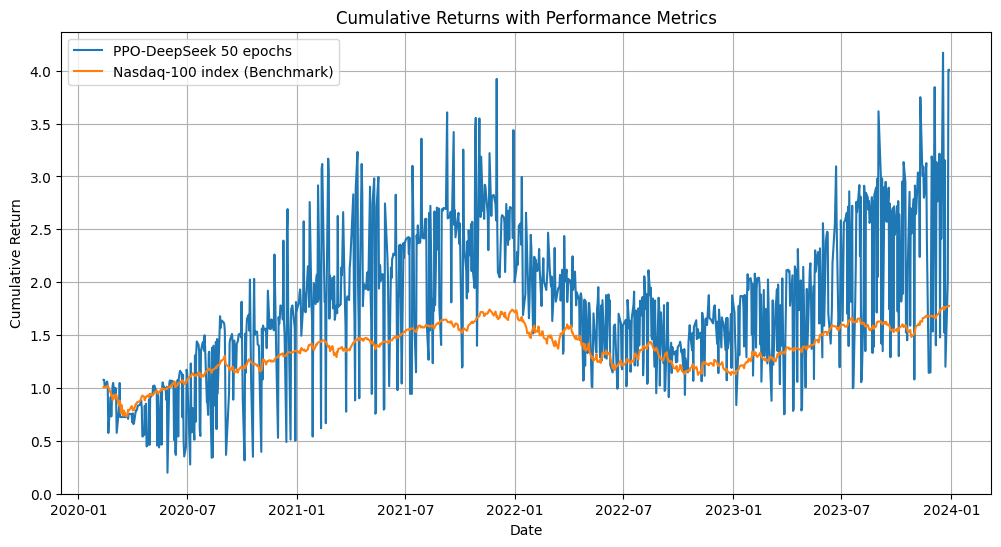

PPO-DeepSeek 50 epochs Metrics:
  Information Ratio: 0.1733
  CVaR: -0.5942
  Rachev Ratio: 3.2726


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Utility Functions
def calculate_metric(returns_strategy, returns_benchmark, confidence_level=0.05, upside_confidence=0.95):
    """Calculate performance metrics: IR, CVaR, and Rachev Ratio."""
    excess_return = returns_strategy - returns_benchmark
    ir = excess_return.mean() / excess_return.std()
    var = np.percentile(returns_strategy, confidence_level * 100)
    cvar = returns_strategy[returns_strategy <= var].mean()
    upside_var = np.percentile(returns_strategy, upside_confidence * 100)
    downside_var = var
    rachev_ratio = returns_strategy[returns_strategy >= upside_var].mean() / abs(returns_strategy[returns_strategy <= downside_var].mean())
    return {"Information Ratio": ir, "CVaR": cvar, "Rachev Ratio": rachev_ratio}

def align_returns(result, col_strategy, col_benchmark):
    """Align returns for strategy and benchmark."""
    returns_strategy = result[col_strategy].pct_change().dropna()
    returns_benchmark = result[col_benchmark].pct_change().dropna()
    return returns_strategy.align(returns_benchmark, join="inner")

# Metrics Calculation
def compute_metrics(result, strategies, benchmark, confidence_level=0.05, upside_confidence=0.95):
    """
    Compute metrics for multiple strategies compared to a benchmark.

    Parameters:
        result (pd.DataFrame): DataFrame with strategies and benchmark columns.
        strategies (list): List of strategy column names.
        benchmark (str): Benchmark column name.
        confidence_level (float): Confidence level for CVaR calculation.
        upside_confidence (float): Confidence level for upside in Rachev Ratio.

    Returns:
        dict: Performance metrics for each strategy.
    """
    metrics = {}
    for strategy in strategies:
        aligned_strategy, aligned_benchmark = align_returns(result, strategy, benchmark)
        metrics[strategy] = calculate_metric(
            aligned_strategy, aligned_benchmark, confidence_level, upside_confidence
        )
    return metrics

# Plotting
def plot_cumulative_returns(result, metrics, strategies, benchmark):
    """
    Plot cumulative returns for strategies and benchmark with annotated metrics.

    Parameters:
        result (pd.DataFrame): DataFrame with strategies and benchmark.
        metrics (dict): Performance metrics.
        strategies (list): List of strategy column names.
        benchmark (str): Benchmark column name.
    """
    plt.figure(figsize=(12, 6))
    for strategy in strategies:
        cumulative_returns = (1 + result[strategy].pct_change().dropna()).cumprod()
        plt.plot(cumulative_returns, label=f"{strategy}")
    cumulative_benchmark = (1 + result[benchmark].pct_change().dropna()).cumprod()
    plt.plot(cumulative_benchmark, label=f"{benchmark} (Benchmark)")
    plt.title("Cumulative Returns with Performance Metrics")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid()
    plt.show()

# Example Usage
# Assuming `result` DataFrame is prepared with "PPO 25 epochs", "CPPO 25 epochs", and "Nasdaq-100 index"
strategies = [

"PPO-DeepSeek 50 epochs",

]
#strategies = ["PPO 20 epochs", "CPPO 20 epochs", "CPPO-DeepSeek 20 epochs"]
benchmark = "Nasdaq-100 index"
metrics = compute_metrics(result, strategies, benchmark)
plot_cumulative_returns(result, metrics, strategies, benchmark)

# Print metrics
for strategy, strategy_metrics in metrics.items():
    print(f"{strategy} Metrics:")
    for metric_name, value in strategy_metrics.items():
        print(f"  {metric_name}: {value:.4f}")

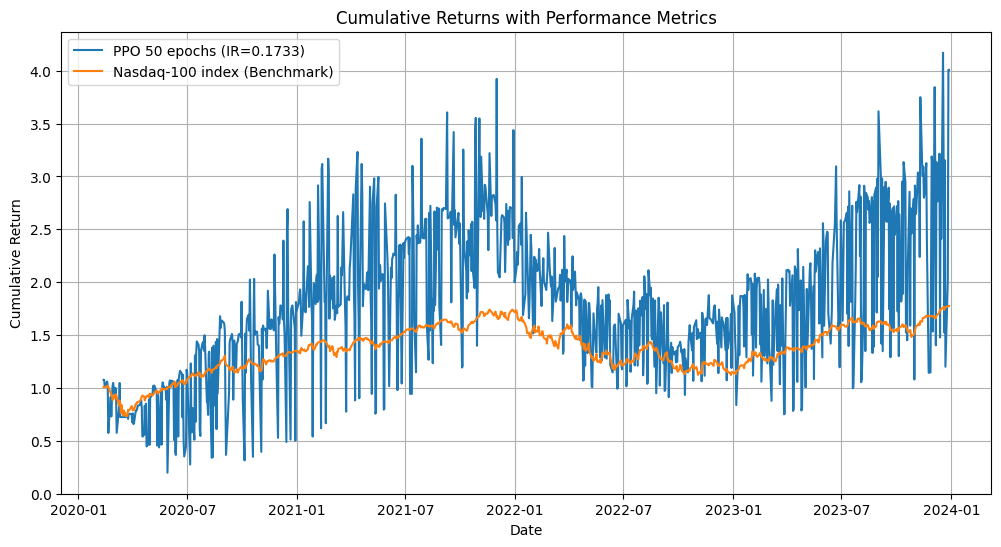

PPO Metrics:
  Information Ratio: 0.1733
  CVaR: -0.5942
  Rachev Ratio: 3.2726


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def calculate_information_ratio(returns_strategy, returns_benchmark):
    """Calculate the Information Ratio (IR)."""
    excess_return = returns_strategy - returns_benchmark
    return excess_return.mean() / excess_return.std()

def calculate_cvar(returns_strategy, confidence_level=0.05):
    """Calculate the Conditional Value at Risk (CVaR)."""
    var = np.percentile(returns_strategy, confidence_level * 100)
    return returns_strategy[returns_strategy <= var].mean()

def calculate_rachev_ratio(returns_strategy, upside_confidence=0.95, downside_confidence=0.05):
    """Calculate the Rachev Ratio."""
    upside_var = np.percentile(returns_strategy, upside_confidence * 100)
    downside_var = np.percentile(returns_strategy, downside_confidence * 100)
    upside_mean = returns_strategy[returns_strategy >= upside_var].mean()
    downside_mean = abs(returns_strategy[returns_strategy <= downside_var].mean())
    return upside_mean / downside_mean

def align_and_compute_metrics(result, confidence_level=0.05, upside_confidence=0.95):
    """
    Align data for PPO, CPPO, and benchmark, and compute performance metrics.

    Parameters:
        result (pd.DataFrame): DataFrame with strategies and benchmark.
        confidence_level (float): Confidence level for CVaR calculation.
        upside_confidence (float): Confidence level for upside in Rachev Ratio.

    Returns:
        dict: Performance metrics for PPO and CPPO.
    """
    # Calculate returns
    returns_ppo = result["PPO-DeepSeek 50 epochs"].pct_change().dropna()
   # returns_cppo = result["CPPO 100 epochs"].pct_change().dropna()
    returns_benchmark = result["Nasdaq-100 index"].pct_change().dropna()

    # Align returns
    returns_ppo, returns_benchmark_ppo = returns_ppo.align(returns_benchmark, join="inner")


    # Compute metrics
    metrics = {
        "PPO": {
            "Information Ratio": calculate_information_ratio(returns_ppo, returns_benchmark_ppo),
            "CVaR": calculate_cvar(returns_ppo, confidence_level),
            "Rachev Ratio": calculate_rachev_ratio(returns_ppo, upside_confidence, confidence_level),
        }
    }
    return metrics

def plot_cumulative_returns(result, metrics):
    """
    Plot cumulative returns for PPO, CPPO, and benchmark with annotated metrics.

    Parameters:
        result (pd.DataFrame): DataFrame with strategies and benchmark.
        metrics (dict): Performance metrics.
    """
    # Calculate cumulative returns
    cumulative_ppo = (1 + result["PPO-DeepSeek 50 epochs"].pct_change().dropna()).cumprod()

    cumulative_benchmark = (1 + result["Nasdaq-100 index"].pct_change().dropna()).cumprod()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_ppo, label=f"PPO 50 epochs (IR={metrics['PPO']['Information Ratio']:.4f})")

    plt.plot(cumulative_benchmark, label="Nasdaq-100 index (Benchmark)")
    plt.title("Cumulative Returns with Performance Metrics")
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid()
    plt.show()

# Example Usage
# Assuming `result` DataFrame is prepared with "PPO 25 epochs", "CPPO 25 epochs", and "Nasdaq-100 index"
metrics = align_and_compute_metrics(result)
plot_cumulative_returns(result, metrics)

# Print metrics
for strategy, strategy_metrics in metrics.items():
    print(f"{strategy} Metrics:")
    for metric_name, value in strategy_metrics.items():
        print(f"  {metric_name}: {value:.4f}")

In [ ]:
print(df_dji.columns)

Index(['date', 'close'], dtype='object', name='Price')


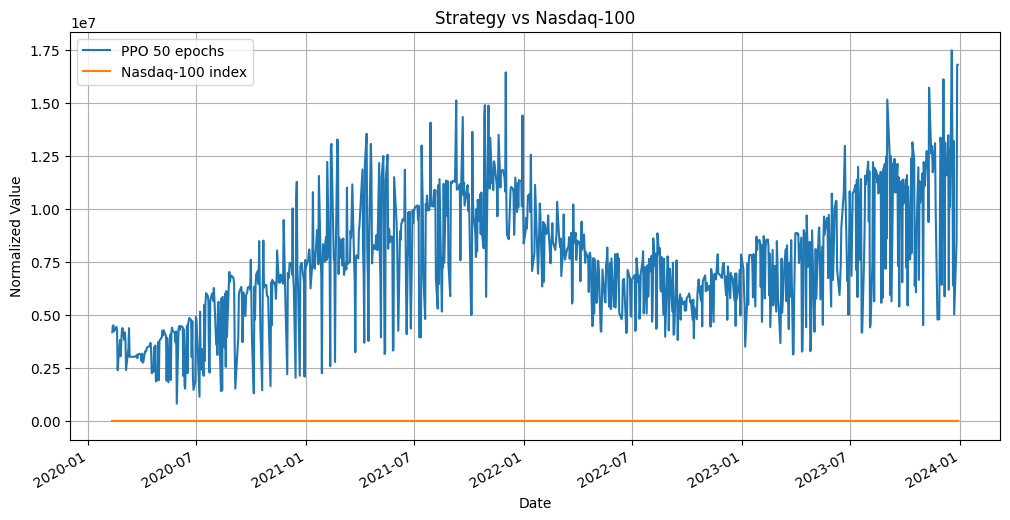

In [ ]:
# Step 1: Get unique trading dates from your trade data
trade_dates = pd.to_datetime(trade['date'].unique())
first_date = trade_dates[0]
date_before_first = first_date - pd.DateOffset(days=1)
trade_dates = pd.DatetimeIndex([date_before_first] + trade_dates.tolist())

# Step 2: Reindex your strategy results to match the extended trading dates
df_assets_ppo_series = pd.Series(df_assets_ppo_llm_filtered, index=trade_dates)

# Step 3: Fix df_dji columns – remove column name and normalize
df_dji.columns.name = None  # Remove 'Price' header name
df_dji['date'] = pd.to_datetime(df_dji['date'])
df_dji = df_dji.set_index('date')
df_dji['normalized_close'] = df_dji['close'] / df_dji['close'].iloc[0]

# Step 4: Align both series using common dates
common_dates = trade_dates.intersection(df_dji.index)
df_assets_ppo_series = df_assets_ppo_series.reindex(common_dates)
df_dji_normalized_close_series = df_dji['normalized_close'].reindex(common_dates)

# Step 5: Create result DataFrame
result = pd.DataFrame({
    "PPO 50 epochs": df_assets_ppo_series,
    "Nasdaq-100 index": df_dji_normalized_close_series,
})

# Optional: Plot the comparison
result.plot(title="Strategy vs Nasdaq-100", figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Normalized Value")
plt.grid(True)
plt.show()

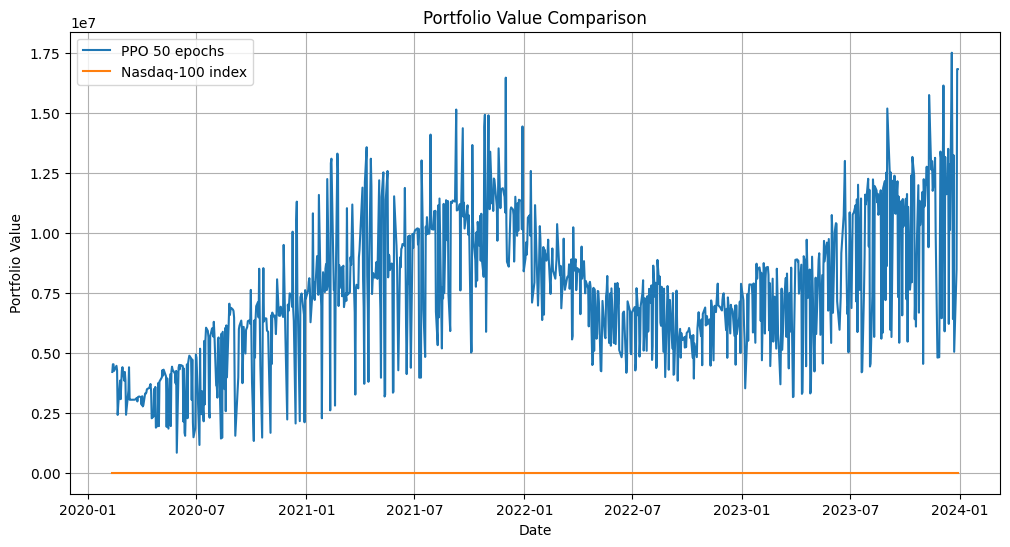

In [ ]:
# prompt: plot also the sharpe ratio and sortino ratio of nasdaq and ppo

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'result' DataFrame is already created as in your provided code

# Calculate daily returns
result['PPO 50 epochs_daily_return'] = result['PPO 50 epochs'].pct_change()
result['Nasdaq-100 index_daily_return'] = result['Nasdaq-100 index'].pct_change()


# Calculate Sharpe Ratio
sharpe_ppo = np.sqrt(252) * (result['PPO 50 epochs_daily_return'].mean() / result['PPO 50 epochs_daily_return'].std())
sharpe_nasdaq = np.sqrt(252) * (result['Nasdaq-100 index_daily_return'].mean() / result['Nasdaq-100 index_daily_return'].std())

# Calculate Sortino Ratio (assuming a target return of 0)
downside_returns_ppo = result['PPO 50 epochs_daily_return'].where(result['PPO 50 epochs_daily_return'] < 0, 0)
downside_returns_nasdaq = result['Nasdaq-100 index_daily_return'].where(result['Nasdaq-100 index_daily_return'] < 0, 0)

sortino_ppo = np.sqrt(252) * (result['PPO 50 epochs_daily_return'].mean() / downside_returns_ppo.std())
sortino_nasdaq = np.sqrt(252) * (result['Nasdaq-100 index_daily_return'].mean() / downside_returns_nasdaq.std())


#Plotting
plt.figure(figsize=(12, 6))
plt.plot(result.index, result['PPO 50 epochs'], label='PPO 50 epochs')
plt.plot(result.index, result['Nasdaq-100 index'], label='Nasdaq-100 index')
plt.title('Portfolio Value Comparison')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)


# Move legend to upper left
plt.legend(loc='upper left')


plt.show()

Information Ratio: 0.1733
CVaR (5%): -0.5942
Rachev Ratio: 3.2726


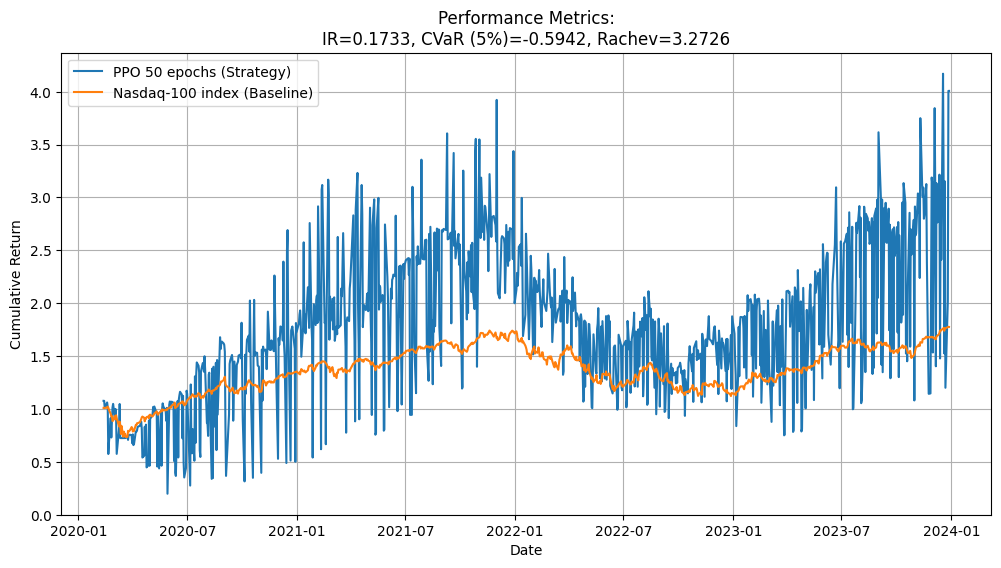

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `df_assets_ppo_series` and `df_dji_normalized_close_series` are already created
returns_strategy = df_assets_ppo_series.pct_change().dropna()
returns_benchmark = df_dji_normalized_close_series.pct_change().dropna()

# Align data
returns_strategy, returns_benchmark = returns_strategy.align(returns_benchmark, join="inner")

# Information Ratio
excess_return = returns_strategy - returns_benchmark
information_ratio = excess_return.mean() / excess_return.std()

# CVaR
confidence_level = 0.05
var = np.percentile(returns_strategy, confidence_level * 100)
cvar = returns_strategy[returns_strategy <= var].mean()

# Rachev Ratio
upside_confidence = 0.95
downside_confidence = 0.05
upside_var = np.percentile(returns_strategy, upside_confidence * 100)
downside_var = np.percentile(returns_strategy, downside_confidence * 100)
rachev_ratio = returns_strategy[returns_strategy >= upside_var].mean() / abs(returns_strategy[returns_strategy <= downside_var].mean())

# Print metrics
print(f"Information Ratio: {information_ratio:.4f}")
print(f"CVaR (5%): {cvar:.4f}")
print(f"Rachev Ratio: {rachev_ratio:.4f}")

# Plot
plt.figure(figsize=(12, 6))

# Strategy and benchmark cumulative returns
cumulative_strategy = (1 + returns_strategy).cumprod()
cumulative_benchmark = (1 + returns_benchmark).cumprod()

plt.plot(cumulative_strategy, label="PPO 50 epochs (Strategy)")
plt.plot(cumulative_benchmark, label="Nasdaq-100 index (Baseline)")

# Add metrics to the plot
plt.title(f"Performance Metrics:\nIR={information_ratio:.4f}, CVaR (5%)={cvar:.4f}, Rachev={rachev_ratio:.4f}")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid()
plt.show()


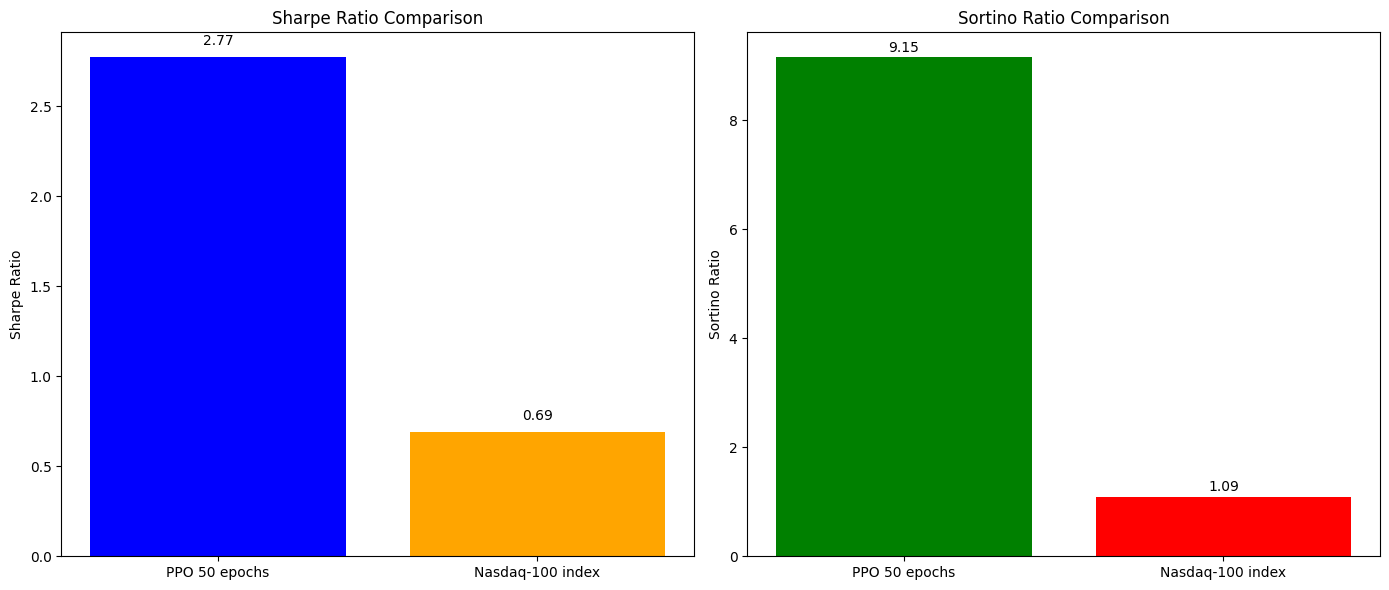

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ... (your existing code to load data and calculate strategies) ...

# Calculate daily returns (same as before)
# ...

# Calculate Sharpe and Sortino Ratios (same as before)
# ...

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# --- Subplot 1: Sharpe Ratio Comparison ---
ax1.bar(['PPO 50 epochs', 'Nasdaq-100 index'], [sharpe_ppo, sharpe_nasdaq], color=['blue', 'orange'])
ax1.set_title('Sharpe Ratio Comparison')
ax1.set_ylabel('Sharpe Ratio')

# Add Sharpe ratio values as text on top of the bars
for i, v in enumerate([sharpe_ppo, sharpe_nasdaq]):
    ax1.text(i, v + 0.05, f"{v:.2f}", ha='center', va='bottom')

# --- Subplot 2: Sortino Ratio Comparison ---
ax2.bar(['PPO 50 epochs', 'Nasdaq-100 index'], [sortino_ppo, sortino_nasdaq], color=['green', 'red'])
ax2.set_title('Sortino Ratio Comparison')
ax2.set_ylabel('Sortino Ratio')

# Add Sortino ratio values as text on top of the bars
for i, v in enumerate([sortino_ppo, sortino_nasdaq]):
    ax2.text(i, v + 0.05, f"{v:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

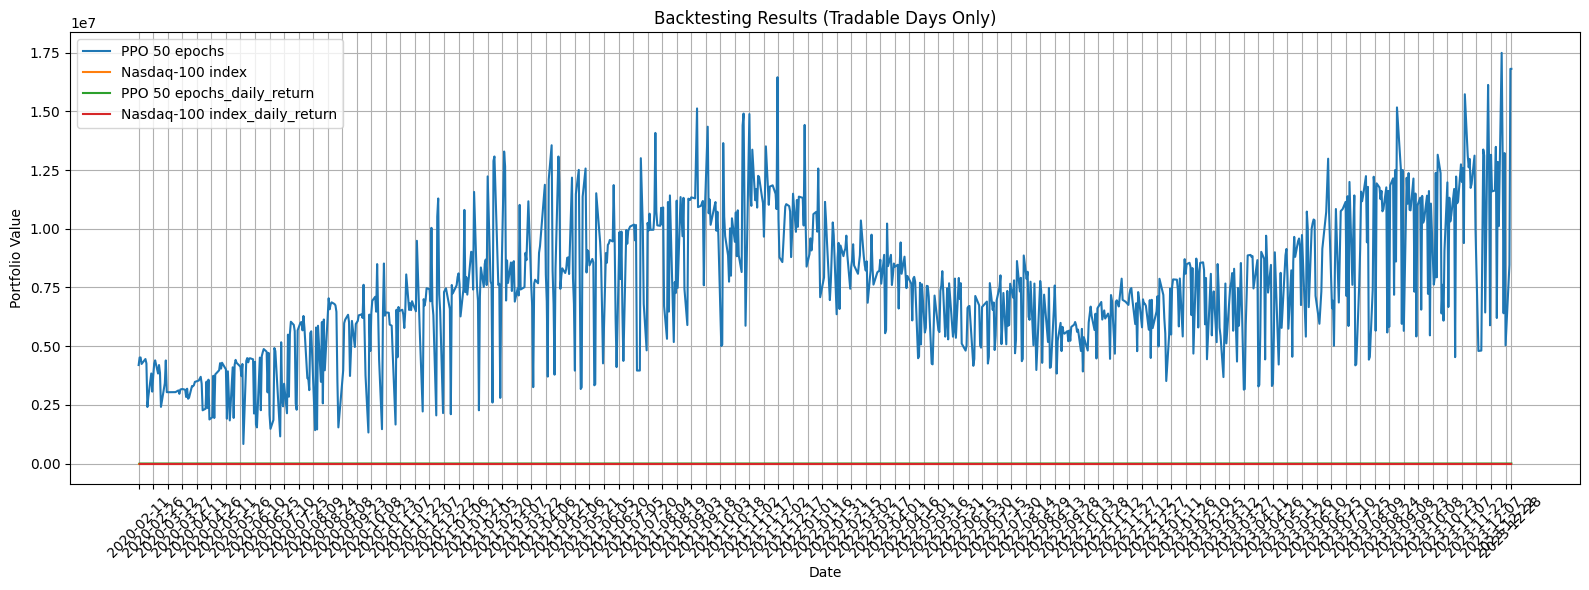

In [ ]:

# Plotting
plt.figure(figsize=(16, 6))
for column in result.columns:
    plt.plot(result.index, result[column], label=column)

plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.title("Backtesting Results (Tradable Days Only)")


# Get the first and last dates from the index
first_day = result.index[0]
last_day = result.index[-1]

# Create a list of dates for ticks, including first, last, and every 15 days
tick_dates = [first_day]  # Start with the first day
current_date = first_day + pd.DateOffset(days=15)  # Add 15 days
while current_date < last_day:
    tick_dates.append(current_date)
    current_date += pd.DateOffset(days=15)
tick_dates.append(last_day)  # Add the last day


# Remove December 13th if it's in the tick_dates list
tick_dates = [d for d in tick_dates if d.strftime('%Y-%m-%d') != '2023-12-13']


# Set x-axis ticks to the calculated tick_dates
plt.xticks(tick_dates, [d.strftime('%Y-%m-%d') for d in tick_dates], rotation=45)


#plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: >

<Figure size 1500x500 with 0 Axes>

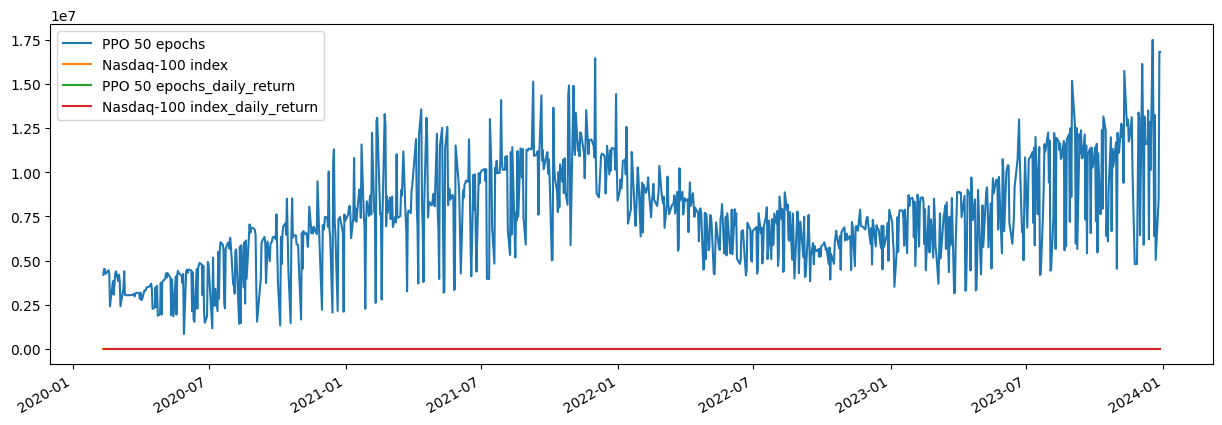

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()

<Axes: >

<Figure size 1500x500 with 0 Axes>

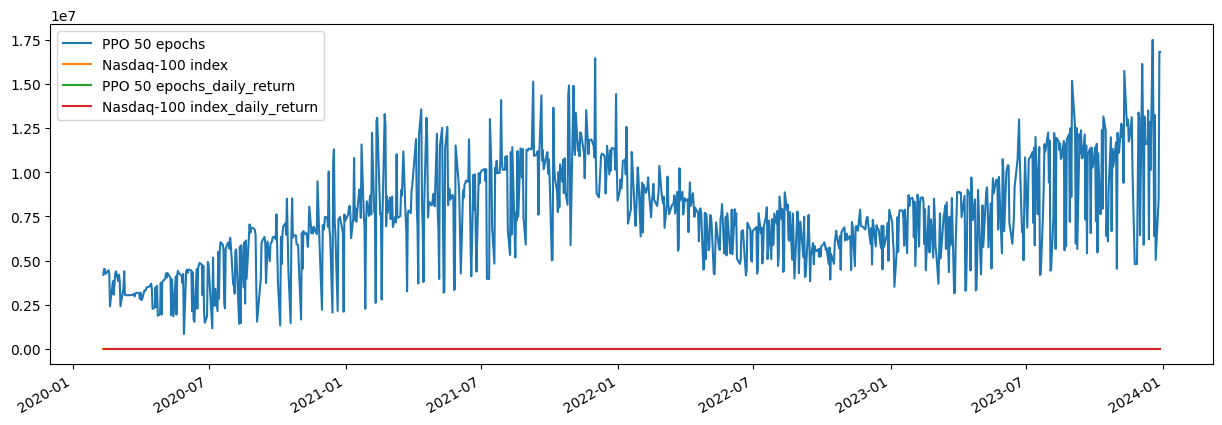

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()